In [4]:

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
import  math, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd

from load_data import create_dataloaders, CFG
from timesformer_min import TimeSformerEncoder

np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models"

In [5]:
# Same loaders; here we *use* labels
dl_train, dl_val, dl_test = create_dataloaders(CFG, batch_size=128, num_workers=4)
for loader in (dl_train, dl_val, dl_test):
    if hasattr(loader, "pin_memory"):
        loader.pin_memory = True

In [6]:
class ThresholdClassifier(nn.Module):
    def __init__(self, encoder: nn.Module, num_classes=8):
        super().__init__()
        self.encoder = encoder
        # infer feature dim
        with torch.no_grad():
            dummy = torch.zeros(2, 7, 1, 32, 64, device=next(encoder.parameters()).device)
            feat_dim = self.encoder(dummy).shape[-1]
        self.classifier = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, num_classes)
        )

    def forward(self, x):            # x: [B,T,1,32,64]
        h = self.encoder(x)          # [B,D]
        logits = self.classifier(h)  # [B,8]
        return logits

# Build encoder with same sizes you used in Step 2
encoder = TimeSformerEncoder(
    in_ch=1, embed_dim=384, depth=6, num_heads=6,
    mlp_ratio=4.0, drop=0.1, attn_drop=0.0,
    patch=(8,8), T=7, H=32, W=64
).to(device)

# Load pretrained SimCLR weights
ckpt = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_ssl_50.pth"
state = torch.load(ckpt, map_location=device)
missing, unexpected = encoder.load_state_dict(state, strict=False), None
print("Loaded pretrain from:", ckpt, "\n(strict=False)")

model = ThresholdClassifier(encoder).to(device)


Loaded pretrain from: C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_ssl_50.pth 
(strict=False)


## metrics

In [7]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    # confusion counts for macro-F1
    num_classes = 8
    TP = torch.zeros(num_classes, dtype=torch.long, device=device)
    FP = torch.zeros(num_classes, dtype=torch.long, device=device)
    FN = torch.zeros(num_classes, dtype=torch.long, device=device)

    for batch in loader:
        x = batch["video"].to(device)           # [B,T,1,32,64]
        y = batch["label"].to(device)           # [B]
        logits = model(x)                       # [B,8]
        pred = logits.argmax(dim=1)             # [B]
        correct += (pred == y).sum().item()
        total += y.numel()

        # per-class stats
        for c in range(num_classes):
            TP[c] += ((pred == c) & (y == c)).sum()
            FP[c] += ((pred == c) & (y != c)).sum()
            FN[c] += ((pred != c) & (y == c)).sum()

    acc = correct / max(1, total)
    # macro-F1
    precision = TP.float() / torch.clamp(TP + FP, min=1)
    recall    = TP.float() / torch.clamp(TP + FN, min=1)
    f1_per_c  = 2 * precision * recall / torch.clamp(precision + recall, min=1e-8)
    macro_f1  = f1_per_c.mean().item()

    return acc, macro_f1, f1_per_c.detach()


## training

In [8]:
use_amp = (device == "cuda")

def train_step(model, batch, opt, scaler):
    model.train()
    x = batch["video"].to(device)
    y = batch["label"].to(device)

    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', enabled=use_amp):
        logits = model(x)
        loss = F.cross_entropy(logits, y)

    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()
    return loss.item()

# --- optimizers & schedulers ---
# Start with linear probe (freeze encoder), then unfreeze
for p in model.encoder.parameters():
    p.requires_grad = False

opt = torch.optim.AdamW(model.classifier.parameters(), lr=5e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5)
scaler = torch.amp.GradScaler(enabled=use_amp)

# --- linear probe epochs ---
lin_epochs = 30
hist = {"train_loss": [], "val_acc": [], "val_f1": []}

for ep in range(1, lin_epochs+1):
    running = 0.0
    for batch in dl_train:
        running += train_step(model, batch, opt, scaler)
    sched.step()

    acc, mf1, _ = evaluate(model, dl_val)
    hist["train_loss"].append(running / max(1, len(dl_train)))
    hist["val_acc"].append(acc)
    hist["val_f1"].append(mf1)
    print(f"[Linear] epoch {ep:02d}  loss {hist['train_loss'][-1]:.4f}  val_acc {acc:.3f}  val_F1 {mf1:.3f}")


[Linear] epoch 01  loss 2.1106  val_acc 0.125  val_F1 0.028
[Linear] epoch 02  loss 2.0834  val_acc 0.125  val_F1 0.028
[Linear] epoch 03  loss 2.0763  val_acc 0.125  val_F1 0.041
[Linear] epoch 04  loss 2.0655  val_acc 0.312  val_F1 0.184
[Linear] epoch 05  loss 2.0598  val_acc 0.263  val_F1 0.149
[Linear] epoch 06  loss 2.0580  val_acc 0.263  val_F1 0.149
[Linear] epoch 07  loss 2.0580  val_acc 0.275  val_F1 0.148
[Linear] epoch 08  loss 2.0521  val_acc 0.300  val_F1 0.175
[Linear] epoch 09  loss 2.0500  val_acc 0.225  val_F1 0.150
[Linear] epoch 10  loss 2.0416  val_acc 0.175  val_F1 0.103
[Linear] epoch 11  loss 2.0338  val_acc 0.438  val_F1 0.349
[Linear] epoch 12  loss 2.0252  val_acc 0.287  val_F1 0.177
[Linear] epoch 13  loss 2.0079  val_acc 0.225  val_F1 0.094
[Linear] epoch 14  loss 2.0071  val_acc 0.250  val_F1 0.101
[Linear] epoch 15  loss 2.0016  val_acc 0.263  val_F1 0.126
[Linear] epoch 16  loss 2.0040  val_acc 0.263  val_F1 0.126
[Linear] epoch 17  loss 1.9965  val_acc 

In [10]:
for p in model.encoder.parameters():
    p.requires_grad = True

opt   = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)
scaler = torch.amp.GradScaler(enabled=use_amp)

best_val = 0.0

def save_ckpt(tag, ep):
    path = os.path.join(save_dir, f"timesformer_cls_{tag}_ep{ep:03d}.pth")
    torch.save(model.state_dict(), path)
    print(f"[ckpt] saved {path}")

ft_epochs = 100

for ep in range(1, ft_epochs+1):
    model.train()
    running = 0.0
    for batch in dl_train:
        running += train_step(model, batch, opt, scaler)
    sched.step()

    acc, mf1, _ = evaluate(model, dl_val)
    tr_loss = running / max(1, len(dl_train))

    # log
    hist["train_loss"].append(tr_loss)
    hist["val_acc"].append(acc)
    hist["val_f1"].append(mf1)

    print(f"[Finetune] epoch {ep:02d}  loss {tr_loss:.4f}  val_acc {acc:.3f}  val_F1 {mf1:.3f}")

    # save: best + every 10 epochs
    if mf1 > best_val:
        best_val = mf1
        torch.save(model.state_dict(), os.path.join(save_dir, "timesformer_cls_best.pth"))
        print("[ckpt] saved best -> timesformer_cls_best.pth")
    if ep % 10 == 0:
        save_ckpt("finetune", ep)



[Finetune] epoch 01  loss 3.4378  val_acc 0.125  val_F1 0.028
[ckpt] saved best -> timesformer_cls_best.pth
[Finetune] epoch 02  loss 2.6619  val_acc 0.125  val_F1 0.028
[Finetune] epoch 03  loss 2.3006  val_acc 0.125  val_F1 0.028
[Finetune] epoch 04  loss 2.1017  val_acc 0.125  val_F1 0.028
[Finetune] epoch 05  loss 2.1384  val_acc 0.125  val_F1 0.028
[Finetune] epoch 06  loss 2.1019  val_acc 0.150  val_F1 0.057
[ckpt] saved best -> timesformer_cls_best.pth
[Finetune] epoch 07  loss 2.0749  val_acc 0.125  val_F1 0.028
[Finetune] epoch 08  loss 2.0842  val_acc 0.125  val_F1 0.028
[Finetune] epoch 09  loss 2.0827  val_acc 0.125  val_F1 0.028
[Finetune] epoch 10  loss 2.0738  val_acc 0.125  val_F1 0.028
[ckpt] saved C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_cls_finetune_ep010.pth
[Finetune] epoch 11  loss 2.0644  val_acc 0.250  val_F1 0.111
[ckpt] saved best -> timesformer_cls_best.pth
[Finetune] epoch 12  loss 2.0615  val_acc 0.250  val_F1 0.101
[Fi

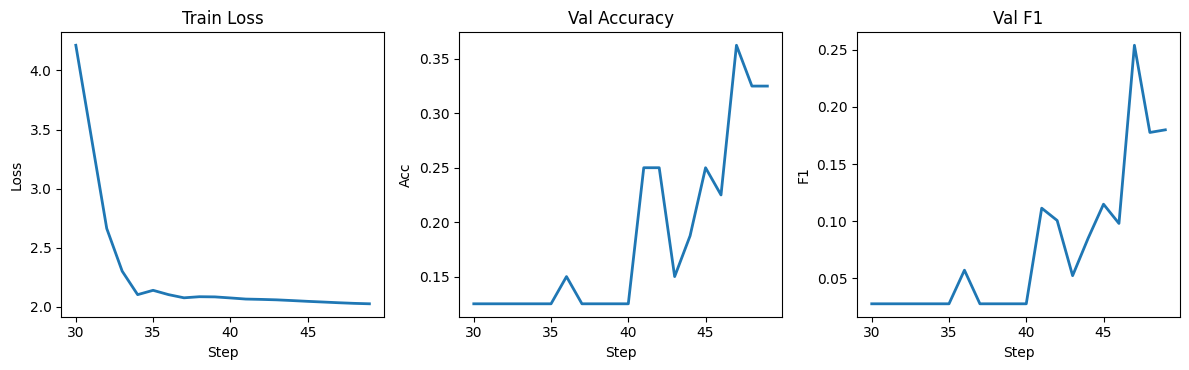

In [12]:
df = pd.DataFrame(hist).iloc[30:50]

fig, axs = plt.subplots(1, 3, figsize=(12, 3.8))
axs[0].plot(df["train_loss"], lw=2); axs[0].set_title("Train Loss"); axs[0].set_xlabel("Step"); axs[0].set_ylabel("Loss")
axs[1].plot(df["val_acc"],  lw=2); axs[1].set_title("Val Accuracy"); axs[1].set_xlabel("Step"); axs[1].set_ylabel("Acc")
axs[2].plot(df["val_f1"],   lw=2); axs[2].set_title("Val F1"); axs[2].set_xlabel("Step"); axs[2].set_ylabel("F1")
plt.tight_layout()
plt.show()

In [17]:
import os, torch, glob
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE

PANOS_DIR = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\panos_buildings"
CKPT_PATH = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_cls_best.pth"

In [20]:
import os, re, glob, torch
from PIL import Image
from torchvision import transforms
from collections import defaultdict

BATCH_SIZE = 64
IMG_SIZE = (32, 64)            # must match your training size
NUM_CLASSES = 8
USE_AMP = (device == "cuda")   # keep CUDA all the way

# --- rebuild model and load weights ---
encoder = TimeSformerEncoder().to(device)
model = ThresholdClassifier(encoder, num_classes=NUM_CLASSES).to(device)
sd = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(sd)
model.eval()

# --- preprocessing for single-channel depth panoramas ---
to_gray_tensor = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),             # -> [1,H,W], float32 in [0,1]
])

# --- group flat files like "..._f00" ... "_f06" into sequences ---
pat = re.compile(r"^(?P<prefix>.+)_f(?P<idx>\d{2})\.(?:png|jpg|jpeg)$", re.IGNORECASE)

def load_seq_from_paths(paths7):
    """paths7: list of 7 frame filepaths ordered by idx -> tensor [7,1,H,W]"""
    imgs = [to_gray_tensor(Image.open(p)) for p in paths7]
    return torch.stack(imgs, dim=0)

# collect all images (flat or recursive if you prefer)
all_imgs = glob.glob(os.path.join(PANOS_DIR, "*.*"))  # change to **/*.* for recursive
groups = defaultdict(list)

for p in all_imgs:
    m = pat.match(os.path.basename(p))
    if not m:
        continue
    prefix = m.group("prefix")                # e.g., "b2_curve_01_peak_021"
    idx = int(m.group("idx"))                 # 00..06
    groups[prefix].append((idx, p))

# build samples: require exactly frames 00..06
samples = []   # list of (id_str, tensor[T=7,1,H,W])
for prefix, items in groups.items():
    if len(items) < 7:
        continue
    items.sort(key=lambda t: t[0])
    # strictly check presence of 0..6
    idxs = [i for i, _ in items[:7]]
    if idxs != list(range(7)):
        # try to find exact 0..6 among possibly more frames
        wanted = {i: None for i in range(7)}
        for i, p in items:
            if i in wanted and wanted[i] is None:
                wanted[i] = p
        if any(v is None for v in wanted.values()):
            continue
        paths7 = [wanted[i] for i in range(7)]
    else:
        paths7 = [p for _, p in items[:7]]

    x = load_seq_from_paths(paths7)           # [7,1,H,W]
    samples.append((prefix, x))

print(f"Found {len(samples)} sequences for inference.")
if samples[:3]:
    print("Example IDs:", [s[0] for s in samples[:3]])


Found 9 sequences for inference.
Example IDs: ['b2_curve_01_peak_021', 'b2_curve_01_peak_033', 'b2_curve_01_peak_040']


In [22]:
# --- batched inference (probs + embeddings) ---
ids, probs_list, feats_list = [], [], []
with torch.no_grad():
    for i in range(0, len(samples), BATCH_SIZE):
        batch_ids = [sid for sid, _ in samples[i:i+BATCH_SIZE]]
        batch = torch.stack([x for _, x in samples[i:i+BATCH_SIZE]], dim=0)  # [B,7,1,H,W]
        batch = batch.to(device, non_blocking=True)

        with torch.amp.autocast(device_type='cuda', enabled=USE_AMP):
            # grab encoder features by calling encoder directly to match your forward()
            h = model.encoder(batch)             # [B,D]
            logits = model.classifier(h)         # [B,8]
            prob = F.softmax(logits, dim=-1)     # [B,8]

        ids.extend(batch_ids)
        probs_list.append(prob.detach().cpu())
        feats_list.append(h.detach().cpu())

probs = torch.cat(probs_list, dim=0).numpy()     # [N,8]
feats = torch.cat(feats_list, dim=0).numpy()     # [N,D]

# --- save CSV with probabilities ---
df = pd.DataFrame(probs, columns=[f"type_{k}" for k in range(NUM_CLASSES)])
df.insert(0, "id", ids)
df.to_csv("modernist_predictions.csv", index=False)
print("Saved modernist_predictions.csv")

PermissionError: [Errno 13] Permission denied: 'modernist_predictions.csv'

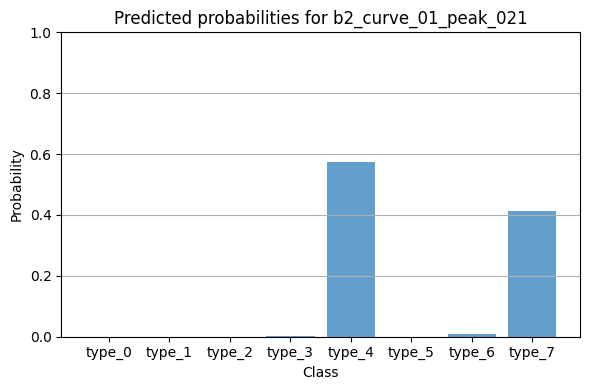

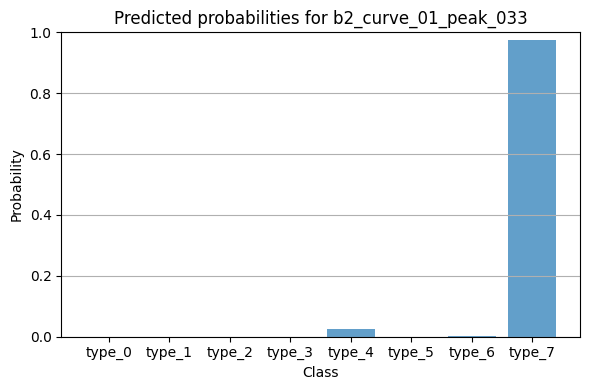

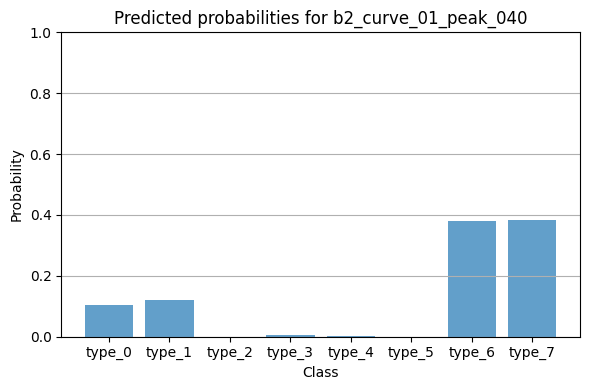

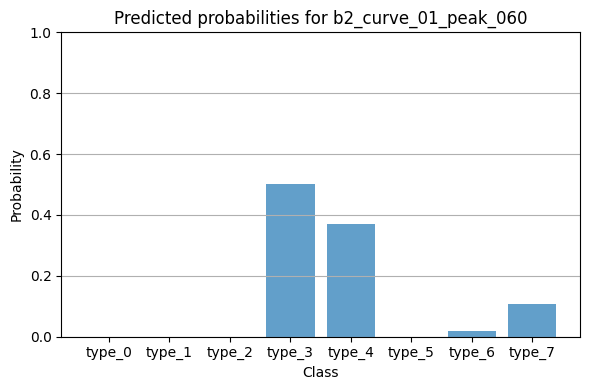

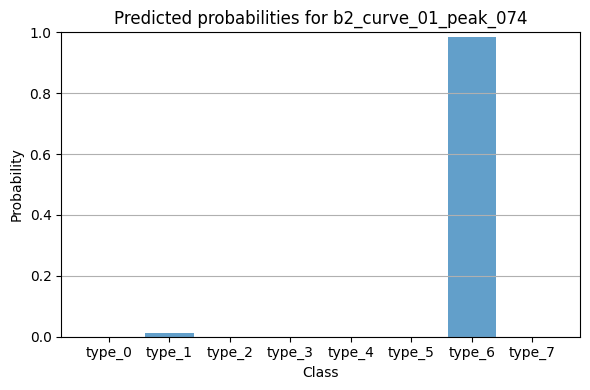

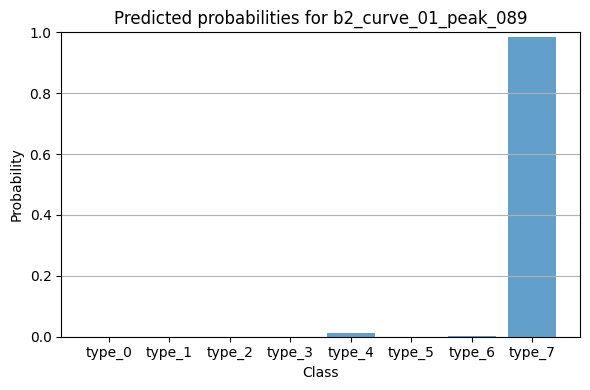

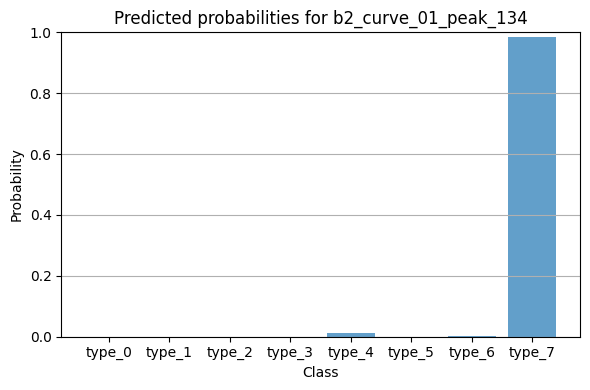

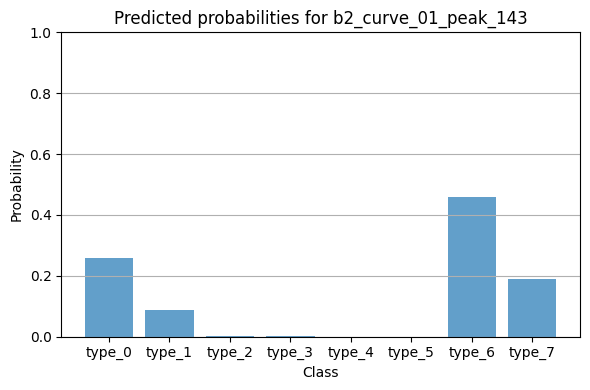

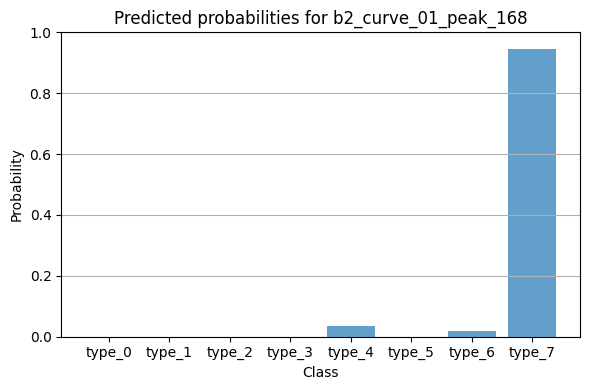

In [26]:
os.makedirs("prob_bars", exist_ok=True)
for sid, p in zip(ids, probs):
    plt.figure(figsize=(6,4))
    plt.bar(np.arange(NUM_CLASSES), p, color='tab:blue', alpha=0.7)
    plt.xticks(np.arange(NUM_CLASSES), [f"type_{k}" for k in range(NUM_CLASSES)])
    plt.ylim(0, 1)
    plt.title(f"Predicted probabilities for {sid}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join("prob_bars", f"{sid}_probs.png"))
    plt.show()
